In [26]:
import pandas as pd 
import wandb
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sklearn.cluster import KMeans
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.ticker import FormatStrFormatter, MaxNLocator

import seaborn as sns
sns.set_style("white")
sns.set(context='notebook',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})

### Rotated MNIST Figure

In [18]:
# ## For target and OOD envs
# def get_results(tag):
#     api = wandb.Api()
#     runs = api.runs("ashwin1996/ood_tl")

#     summary_list, config_list, name_list = [], [], []
#     m_n = []
#     avg_error = []
#     std_error = []
#     ood = []
#     for run in runs: 
#         try:
#             run_tag = run.config['tag'] 
#         except KeyError:
#             run_tag = "None"
#         if run_tag == tag:
#             summary_list.append(run.summary._json_dict)
#             config_list.append(
#                 {k: v for k,v in run.config.items()
#                 if not k.startswith('_')})
#             # print(config_list)
#             name_list.append(run.name)
#             m_n.append(run.config['task']['m_n'])
#             avg_error.append(run.summary['avg_err'])
#             std_error.append(run.summary['std_err'])
#             ood.append(run.config['task']['angle'])

#     runs_df = pd.DataFrame({
#         "ood": ood,
#         "m_n": m_n,
#         "avg_error": avg_error,
#         "std_error": std_error,
#         "summary": summary_list,
#         "config": config_list,
#         "name": name_list
#         })

#     return runs_df

In [19]:
# df_exp = get_results("14_domainbed/rotated_mnist_smallconv")
# df_exp = df_exp.sort_values(by=['ood','m_n']).reset_index(drop=True)
# df_exp.to_csv("results/01_rotated_mnist.csv")

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


In [15]:
df_runs = pd.read_csv("results/01_rotated_mnist.csv")

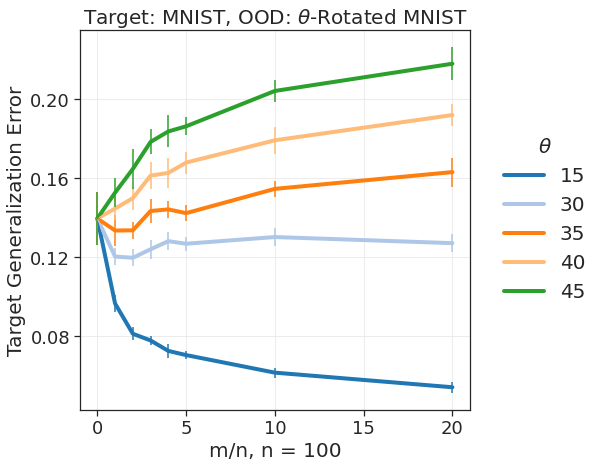

In [16]:
# rotated mnist 
env_list = [15, 30, 35, 40, 45]
reps = 10
n = 100

cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, ax = plt.subplots(figsize=(7, 7))
fontsize = 20
labelsize = 18

for i, env in enumerate(env_list):
    # mnist 
    df = df_runs[df_runs['ood'] == env].reset_index(drop=True)

    m_n = df['m_n'].to_numpy()
    avg_error = df['avg_error'].to_numpy()
    std_error = df['std_error'].to_numpy()
    ci = 1.96 * std_error / np.sqrt(reps)
    ax.plot(m_n, avg_error, color=cmap[i], label=env_list[i], lw=4)
    # ax.fill_between(m_n, avg_error  - ci, avg_error + ci, color=cmap[i], alpha=0.2)
    ax.errorbar(m_n, avg_error, yerr=ci, color=cmap[i])
    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    
    ax.set_xlabel("m/n, n = {}".format(n), fontsize=fontsize)
    ax.set_title(r"Target: MNIST, OOD: $\theta$-Rotated MNIST", fontsize=fontsize)

    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))
# mnist 
legend = ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=fontsize, title=r"$\theta$", frameon=False)
legend.get_title().set_fontsize(fontsize)

plt.show()

In [17]:
filename = "rotatedMNIST_curves"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

In [6]:
from datahandlers.mnist import RotatedMNISTDataset

0
1
2
3
4
5
6
7
8


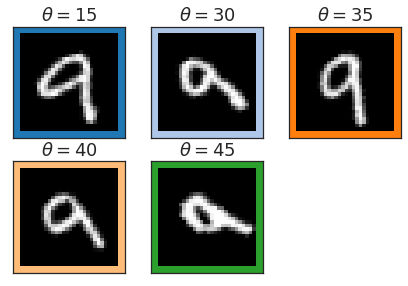

In [7]:
env_list = [15, 30, 35, 40, 45]
cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, axes = plt.subplots(3, 3, figsize=(7, 7))

for i, ax in enumerate(axes.reshape(-1)):
    print(i)
    if i+1 > len(env_list):
        ax.set_visible(False)
        continue
    dataset = RotatedMNISTDataset(angles=[0, env_list[i]])
    targets = np.array(dataset.targets)
    data = dataset.data
    labels = targets[targets[:,0]==1][:, 1]
    data = data[targets[:,0]==1]
    idx = np.where(labels == 9)[0][0]

    pad = np.zeros((32, 32, 3))
    pad[:, :, 0] = cmap[i][0]
    pad[:, :, 1] = cmap[i][1]
    pad[:, :, 2] = cmap[i][2]

    im = np.zeros((28, 28, 3))
    im[:, :, 0] = data[idx].squeeze()
    im[:, :, 1] = data[idx].squeeze()
    im[:, :, 2] = data[idx].squeeze()

    pad[2:-2, 2:-2, :] = im

    ax.imshow(pad)
    ax.grid(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title(r"$\theta = {}$".format(env_list[i]), fontsize=labelsize)

In [8]:
filename = "rotatedMNIST_examples"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

### PACS

In [10]:
# api = wandb.Api()
# runs = api.runs("ashwin1996/ood_tl")
# tag = "14_domainbed/3_pacs_wrn16-4"

# summary_list, config_list, name_list = [], [], []
# m_n = []
# n = 0
# m = []
# target = []
# ood = []
# avg_error = []
# std_error = []
# task = []
# for run in runs: 
#     try:
#         run_tag = run.config['tag'] 
#     except KeyError:
#         run_tag = "None"
#     if run_tag == tag:
#         summary_list.append(run.summary._json_dict)
#         config_list.append(
#             {k: v for k,v in run.config.items()
#             if not k.startswith('_')})
#         name_list.append(run.name)
#         m_n.append(run.config['task']['m_n'])
#         m.append(run.summary['m'])
#         n = run.summary['n']
#         target.append(run.config['task']['target_env'])
#         ood.append(run.config['task']['ood_env'])
#         avg_error.append(run.summary['avg_err'])
#         std_error.append(run.summary['std_err'])
#         task.append(run.config['task']['target'])

# runs_df = pd.DataFrame({
#     "m_n": m_n,
#     "m": m,
#     "avg_error": avg_error,
#     "std_error": std_error,
#     "task": task,
#     "target": target,
#     "ood": ood,
#     "summary": summary_list,
#     "config": config_list,
#     "name": name_list
#     })
# runs_df = runs_df.sort_values(by=['target','ood','m_n']).reset_index(drop=True)

In [11]:
# runs_df.to_csv("results/02_pacs.csv")

In [18]:
df_runs = pd.read_csv("results/02_pacs.csv")

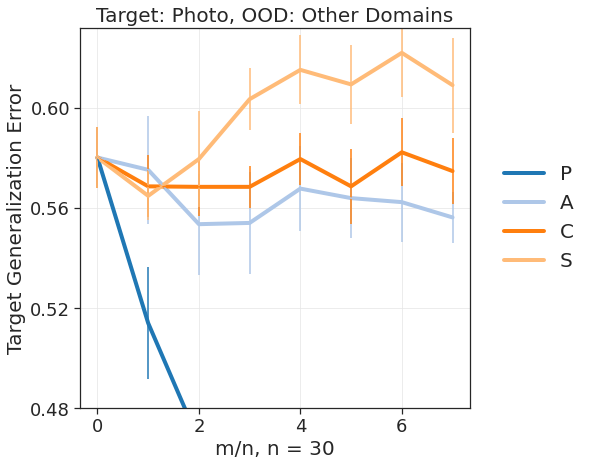

In [24]:
# PACS
env_list = ["P", "A", "C", "S"]
env_long_list = ["Photo", "Art", "Cartoon", "Sketch"]
n = 30
reps = 10

cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, ax = plt.subplots(figsize=(7, 7))
fontsize = 20
labelsize = 18

for i, env in enumerate(env_list):
    df = df_runs[df_runs['ood'] == env].reset_index(drop=True)

    m_n = df['m_n'].to_numpy()
    avg_error = df['avg_error'].to_numpy()
    std_error = df['std_error'].to_numpy()
    ci = 1.96 * std_error / np.sqrt(reps)
    m_n = m_n[:8]
    avg_error = avg_error[:8]
    ci = ci[:8]
    ax.plot(m_n, avg_error, color=cmap[i], label=env_list[i], lw=4)
    # ax.fill_between(m_n, avg_error  - ci, avg_error + ci, color=cmap[i], alpha=0.2)
    ax.errorbar(m_n, avg_error, yerr=ci, color=cmap[i])
    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    ax.set_ylim([0.48, avg_error.max()+0.01])
    
    ax.set_xlabel("m/n, n = {}".format(n), fontsize=fontsize)
    ax.set_title(r"Target: Photo, OOD: Other Domains", fontsize=fontsize)

    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))

# pacs 
legend = ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=fontsize, frameon=False)
legend.get_title().set_fontsize(fontsize)


In [25]:
filename = "PACS_curves"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

In [26]:
from datahandlers.pacs import PACSHandler
import hydra
import omegaconf

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


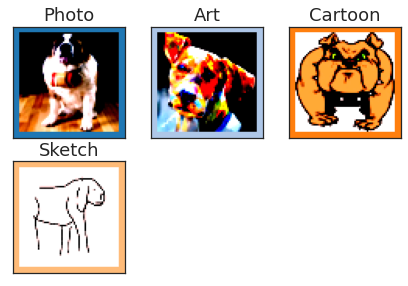

In [28]:
env_list = ["P", "A", "C", "S"]
env_long_list = ["Photo", "Art", "Cartoon", "Sketch"]
cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, axes = plt.subplots(3, 3, figsize=(7, 7))

for i, ax in enumerate(axes.reshape(-1)):
    if i+1 > len(env_list):
        ax.set_visible(False)
        continue

    cfg = omegaconf.OmegaConf.load('/cis/home/adesilva/ashwin/research/ood-tl/config/conf.yaml')
    cfg.task.target_env = "P"
    cfg.task.ood_env = env_list[i]
    cfg.task.task_map = [[0,1,4]]
    cfg.task.n=20
    cfg.task.m_n=1
    cfg.hp.bs=1

    dataset = PACSHandler(cfg)
    dataset.sample_data(1996)

    targets = np.array(dataset.comb_trainset.targets)
    data = dataset.comb_trainset.data
    labels = targets[targets[:,0]==1][:, 1]
    data = data[targets[:,0]==1]
    dataset.comb_trainset.data = data
    if i == 0:
        idx = np.where(labels == 0)[0][1]
    elif i == 1:
        idx = np.where(labels == 0)[0][1]
    else:
        idx = np.where(labels == 0)[0][0]

    pad = np.zeros((72, 72, 3))
    pad[:, :, 0] = cmap[i][0]
    pad[:, :, 1] = cmap[i][1]
    pad[:, :, 2] = cmap[i][2]

    im = dataset.comb_trainset.__getitem__(idx)[0].numpy().transpose(1, 2, 0)

    pad[4:-4, 4:-4, :] = im

    ax.imshow(pad)
    ax.grid(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title("{}".format(env_long_list[i]), fontsize=labelsize)

In [29]:
filename = "PACS_examples"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

### Domain-Net

In [30]:
import glob

In [36]:
def get_results(id):
    mval = []
    err = []
    std = []

    for fname in glob.glob("/cis/home/adesilva/ashwin/research/ood-tl/logs/05_ood/0{}_domain_net/*".format(id)):
        with open(fname, "r") as fp:
            cont = fp.readlines()

        cfg = eval(cont[0])
        dictt = eval(cont[-1])

        mval.append(cfg['task']['m_n'])
        err.append(dictt['avg_err'])
        std.append(dictt['std_err'])

    print(mval)
    print(err)
    err = np.array(err)
    mval = np.array(mval)
    std = np.array(std)

    ind = np.argsort(mval)
    mval = mval[ind]
    std = std[ind]
    err = err[ind]

    return err, std, mval

[1, 4, 8, 9, 0, 3, 6, 7, 5, 2, 10, 0.25, 0.5]
[0.2202, 0.1296, 0.1235, 0.1114, 0.2518, 0.1436, 0.1248, 0.1202, 0.1309, 0.1638, 0.1111, 0.2166, 0.2114]
[0.25, 4, 9, 2, 6, 3, 5, 7, 1, 0, 10, 0.5, 8]
[0.2248, 0.1912, 0.2065, 0.2033, 0.1863, 0.1902, 0.1925, 0.1886, 0.1896, 0.2518, 0.1961, 0.2169, 0.2192]
[0, 9, 3, 1, 7, 0.5, 5, 0.25, 10, 6, 4, 2, 8]
[0.2518, 0.172, 0.1906, 0.2241, 0.1743, 0.2189, 0.1912, 0.2098, 0.1619, 0.1674, 0.1808, 0.2303, 0.1573]
[1, 4, 0.25, 3, 8, 10, 5, 9, 7, 2, 6, 0.5, 0]
[0.2182, 0.2121, 0.2218, 0.2254, 0.2365, 0.2365, 0.2293, 0.2365, 0.2365, 0.2257, 0.2345, 0.2179, 0.2518]
[8, 3, 0.5, 5, 7, 0.25, 6, 9, 10, 0, 2, 4, 1]
[0.1948, 0.1889, 0.2114, 0.1896, 0.1938, 0.2169, 0.1831, 0.184, 0.1987, 0.2518, 0.2134, 0.1928, 0.2134]


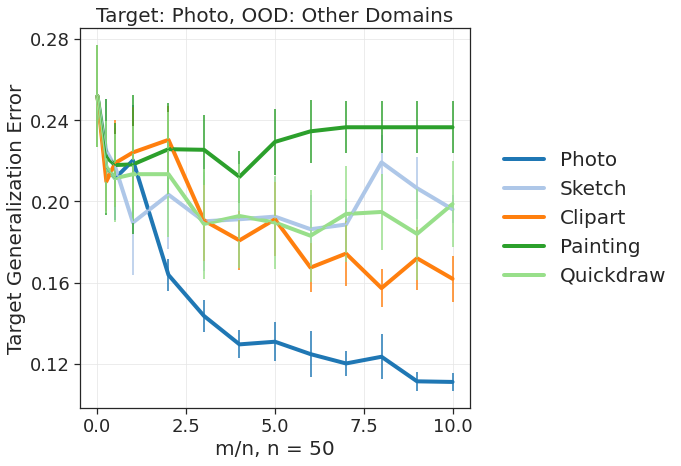

In [42]:
env_list = ["Photo", "Sketch", "Clipart", "Infograph", "Painting", "Quickdraw"]

cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, ax = plt.subplots(figsize=(7, 7))
fontsize = 20
labelsize = 18
n = 50

for i, env in enumerate(env_list):
    if env == "Infograph":
        continue
    avg_error, std_error, m_n = get_results(i)
    ci = 1.96 * std_error / np.sqrt(10)
    ax.plot(m_n, avg_error, color=cmap[i], label=env_list[i], lw=4)
    # ax.fill_between(m_n, avg_error  - ci, avg_error + ci, color=cmap[i], alpha=0.2)
    ax.errorbar(m_n, avg_error, yerr=ci, color=cmap[i])
    ax.set_ylabel("Target Generalization Error", fontsize=fontsize)
    # ax.set_ylim([0.45, avg_error[:6].max()+0.01])
    
    ax.set_xlabel("m/n, n = {}".format(n), fontsize=fontsize)
    ax.set_title(r"Target: Photo, OOD: Other Domains", fontsize=fontsize)

    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(5))

# pacs 
legend = ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", fontsize=fontsize, frameon=False)
legend.get_title().set_fontsize(fontsize)


In [43]:
filename = "DomainNet_curves"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")

In [49]:
from skimage.io import imread
from skimage.transform import resize

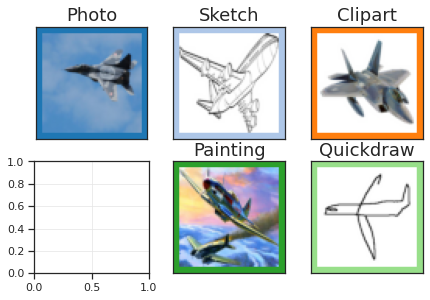

In [56]:
env_list = [
    "Photo", 
    "Sketch", 
    "Clipart", 
    # "Infograph", 
    "Painting", 
    "Quickdraw"
    ]
cmap = [plt.cm.tab20(i) for i in range(len(env_list))]
fig, axes = plt.subplots(3, 3, figsize=(7, 7))

filenames = [
    'DomainNet_env4real_23_idx1778_class4.png',
    'DomainNet_env5sketch_2_idx904_class4.png',
    'DomainNet_env0clipart_9_idx455_class4.png',
    # 'DomainNet_env1infograph_6_idx496_class4.png',
    'DomainNet_env2painting_34_idx891_class4.png',
    'DomainNet_env3quickdraw_8_idx2376_class4.png'
]

axes = axes.reshape(-1)
for i, ax in enumerate(axes.reshape(-1)):
    if i+1 > len(env_list):
        ax.set_visible(False)
        continue
    
    im = imread("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/assets/"+filenames[i])
    im = resize(im, (64, 64), anti_aliasing=True)

    pad = np.zeros((72, 72, 3))
    pad[:, :, 0] = cmap[i][0]
    pad[:, :, 1] = cmap[i][1]
    pad[:, :, 2] = cmap[i][2]

    pad[4:-4, 4:-4, :] = im

    ax.imshow(pad)
    ax.grid(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_title("{}".format(env_list[i]), fontsize=labelsize)

In [55]:
filename = "DomainNet_examples"
fig.savefig("/cis/home/adesilva/ashwin/research/Non-Monotonic-OOD-Risk/figures/{}.eps".format(filename), bbox_inches="tight")